In [1]:
# Importing libraries
import sys
import pathlib
import warnings
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy import signal
import scipy.io
import math
from skimage.morphology import erosion
warnings.filterwarnings("ignore")

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

In [4]:
'''
list_Huy=(\
'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim' \
'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM' \
'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM' \
)
mask_list=(\
'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0.zip' \
'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM/masks_MS2-CY5_Cyto543_560_18minTPL_5uM___nuc_70__cyto_0.zip' \
'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM/masks_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_70__cyto_0.zip' \
)
'''

"\nlist_Huy=('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim' 'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM' 'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM' )\nmask_list=('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0.zip' 'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM/masks_MS2-CY5_Cyto543_560_18minTPL_5uM___nuc_70__cyto_0.zip' 'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM/masks_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_70__cyto_0.zip' )\n"

In [5]:
# Path to images and masks
data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')
path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0.zip') 

In [6]:
download_data_from_NAS = True
send_data_to_NAS = False

In [7]:
%%capture
# Download data from NAS
local_data_dir, masks_dir, _, _, list_file_names = fa.Utilities.read_images_from_folder( path_to_config_file, data_folder_path, 
                                                                                            path_to_masks_dir,  download_data_from_NAS)


In [8]:
local_data_dir

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks/temp_MS2-CY5_Cyto543_560_woStim/merged')

In [9]:
masks_dir

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0')

In [10]:
list_file_names

['ROI001_XY1657814108_Z00_T0',
 'ROI005_XY1657814112_Z00_T0',
 'ROI009_XY1657814116_Z00_T0',
 'ROI010_XY1657814117_Z00_T0',
 'ROI011_XY1657814118_Z00_T0',
 'ROI002_XY1657815441_Z00_T0',
 'ROI003_XY1657814110_Z00_T0',
 'ROI007_XY1657814114_Z00_T0',
 'ROI008_XY1657814115_Z00_T0',
 'ROI012_XY1657814119_Z00_T0',
 'ROI004_XY1657814111_Z00_T0',
 'ROI006_XY1657814113_Z00_T0']

In [11]:
# Path to read each file with masks.
NUM_POINTS_MASK_EDGE_LINE = 100
for file_id , temp_file_name in enumerate (list_file_names):
    mask_nuc_path = masks_dir.absolute().joinpath('masks_nuclei_' + temp_file_name +'_merged.tif' )
    masks_nuclei = imread(str(mask_nuc_path ))
    # iterate for each mask
    n_masks =np.max(masks_nuclei)  
    tensor_masks = np.zeros((n_masks,NUM_POINTS_MASK_EDGE_LINE,2))               
    for i in range(1, n_masks+1 ):
        # Removing the borders just for plotting
        tested_mask_nuc = np.where(masks_nuclei == i, 1, 0).astype(bool)
        # removing pixels outside the main mask
        tested_mask_nuc = erosion(tested_mask_nuc)
        # Remove border for plotting
        temp_contour_n = find_contours(tested_mask_nuc, 0.1, fully_connected='high',positive_orientation='high')
        contours_connected_n = np.vstack((temp_contour_n))
        contour_n = np.vstack((contours_connected_n[-1,:],contours_connected_n))
        # Downsample the array using signal.resample
        downsampled_mask = signal.resample(contour_n, num = NUM_POINTS_MASK_EDGE_LINE)
        tensor_masks[i-1,:,:] = downsampled_mask
    # Concatenate mask tensor.
    if file_id ==0:
        merged_mask_tensors = tensor_masks
    if file_id >0:
        merged_mask_tensors = np.concatenate((merged_mask_tensors, tensor_masks), axis=0)
    del tensor_masks,masks_nuclei


In [12]:
merged_mask_tensors.shape


(155, 100, 2)

In [13]:
NUM_COLUMNS = 10
number_cells = merged_mask_tensors.shape[0]
NUM_ROWS = math.ceil(number_cells/ 10)


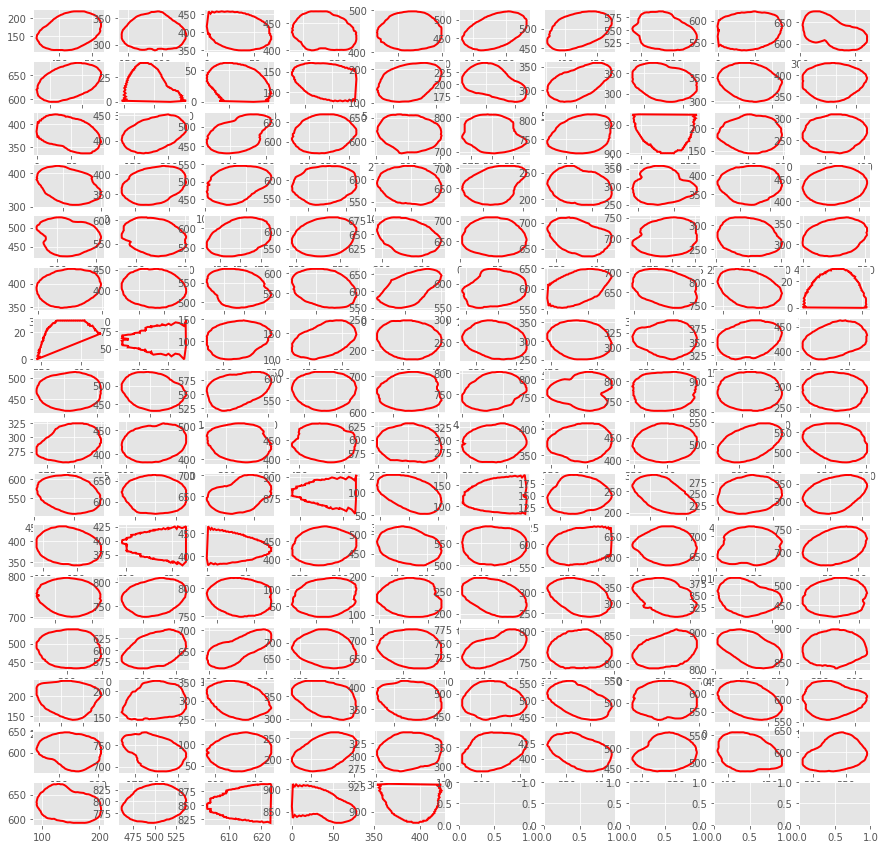

In [14]:
# plotting maks as contours.
_, axes = plt.subplots(nrows = NUM_ROWS, ncols = NUM_COLUMNS, figsize = (15, 15))
r = 0
c = 0
for i in range(0, number_cells):
    axes[r,c].fill(merged_mask_tensors[i,:, 1], merged_mask_tensors[i,:, 0], facecolor = 'none', edgecolor = 'red', linewidth=2) # mask nucleus
    c+=1
    if (c>0) and (c%10 ==0):
        c=0
        r+=1
plt.show()

In [17]:
mask_dic = {"merged_mask_tensors": merged_mask_tensors}

In [18]:
scipy.io.savemat('masks_coordinates_wo.mat', mask_dic)